### Introduction:

Company XYZ is a food delivery company. Like pretty much any other site, in order to get customers, they have been relying significantly on online ads, such as those you see on Google or Facebook.

At the moment, they are running 40 different ad campaigns and want you to help them understand their performance.

### Specifically, you are asked to:

1. If you had to identify the 5 best ad groups, which ones would be? Which metric did you choose to identify the best ones? Why? Explain the pros of your metric as well as the possible cons. From a business perspective, choosing that metric implies that you are focusing on what?


2. For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).


3. Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.


### Data
https://drive.google.com/uc?export=download&id=1wB3x3bPIX7C19Rmse1bpZtYBmVcrPDGa


### The table is:
ad_table - aggregate information about ads

### Columns:
date : all data are aggregated by 

date shown : the number of ads shown on a given day all over the web. Impressions are free. That is, companies pay only if a user clicks on the ad, not to show it 

clicked : the number of clicks on the ads. This is what companies pay for. By clicking on the ad, the user is brought to the site 

converted : the number of conversions on the site coming from ads. To be counted, a conversion as to happen on the same day as the ad click. 

avg_cost_per_click : on an average, how much it cost each of those clicks 

total_revenue : how much revenue came from the conversions ad : we have several different ad versions with different text. This shows which ad group we are considering

# Loading libraries and data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
url = 'https://drive.google.com/uc?export=download&id=1wB3x3bPIX7C19Rmse1bpZtYBmVcrPDGa'
data = pd.read_csv(url)

data['date'] = pd.to_datetime(data['date'])
data.dtypes

date                  datetime64[ns]
shown                          int64
clicked                        int64
converted                      int64
avg_cost_per_click           float64
total_revenue                float64
ad                            object
dtype: object

# Descriptive Statistics

In [29]:
print(data.shape)
data.describe()

(2115, 7)


,date,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2115,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000
mean,2015-10-27 00:02:43.404255232,68299.844444,3056.077069,126.453901,1.373749,1966.517589
min,2015-10-01 00:00:00,0.000000,0.000000,0.000000,0.000000,-200.150000
25%,2015-10-14 00:00:00,28030.500000,744.000000,18.000000,0.760000,235.470000
50%,2015-10-27 00:00:00,54029.000000,1392.000000,41.000000,1.400000,553.300000
75%,2015-11-09 00:00:00,97314.500000,3366.500000,103.000000,1.920000,1611.495000
max,2015-11-22 00:00:00,192507.000000,20848.000000,1578.000000,4.190000,39623.710000
std,NaN,48884.821409,3783.579969,233.420826,0.754331,3942.018757


### Obervations:
data needs to be cleaned because:

on some days, shown and clicked are both 0, which is unlikely

# Clean Data

In [30]:
# index data with negative revenue
i = data[data['total_revenue'] < 0].index

# drop those data
data = data.drop(i)
data.shape


(2111, 7)

In [31]:
#check and see if funnel makes sense
print("there are",len(data.query('shown<clicked | clicked < converted')),"events that doesn't conform to funnel")


there are 0 events that doesn't conform to funnel


dropped 13 rows


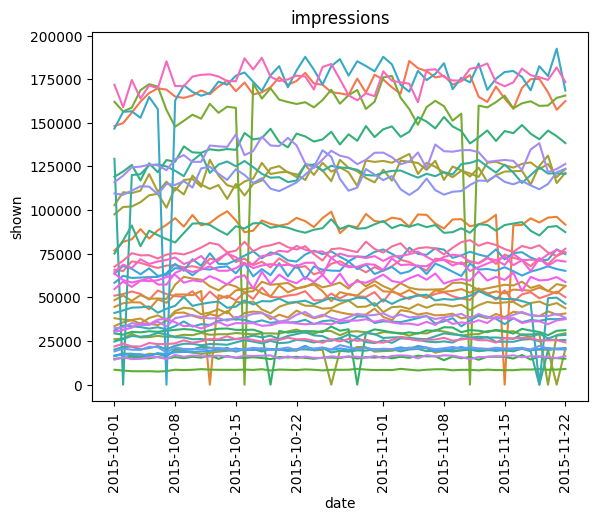

In [32]:
# check 0 values

#0 impression
g = sns.lineplot(x = "date", y = "shown", hue ="ad", data=data, legend="" )
plt.xticks(rotation = 90)
plt.title("impressions")
plt.show

# drop 0 impressions
i = data[data['shown']==0].index
data = data.drop(i)
print("dropped",len(i),"rows")


dropped 7 rows


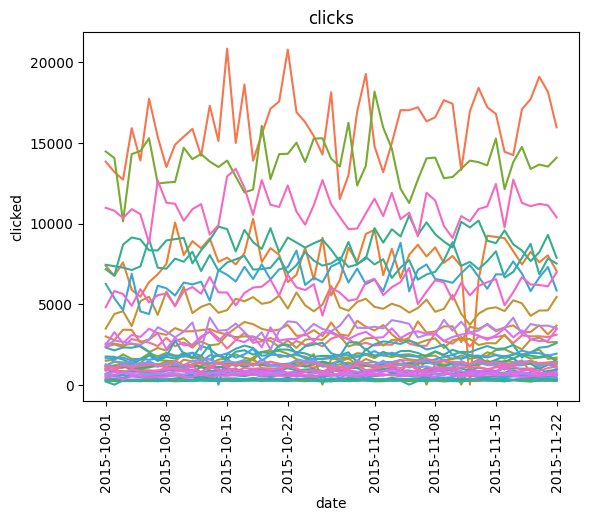

In [33]:
# check 0 values

# 0 clicked
g = sns.lineplot(x = "date", y = "clicked", hue = "ad", data=data, legend="")
plt.xticks(rotation = 90)
plt.title("clicks")
plt.show

# drop 0 clicks
i = data[data['clicked']==0].index
data = data.drop(i)
print("dropped",len(i),"rows")

dropped 52 rows


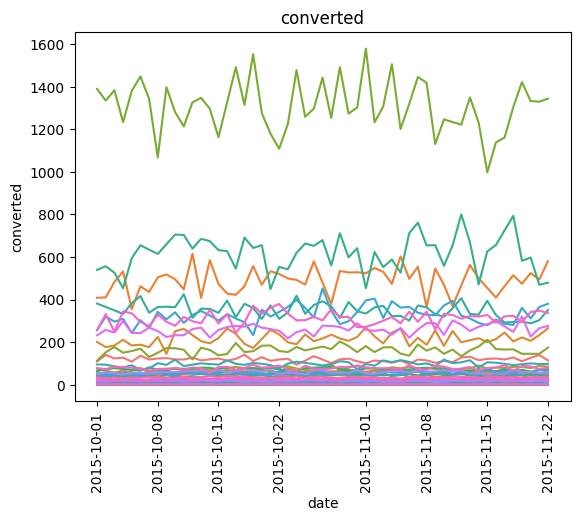

In [34]:
# check 0 values

# 0 converted
g = sns.lineplot(x = "date", y = "converted", hue = "ad", data=data, legend="")
plt.xticks(rotation = 90)
plt.title("converted")
plt.show

# drop 0 clicks
i = data[data['converted']==0].index
data = data.drop(i)
print("dropped",len(i),"rows")


In [35]:
# check cleaned data
print(data.shape)
round(data.describe(),0)


(2039, 7)


,date,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2039,2039.0,2039.0,2039.0,2039.0,2039.0
mean,2015-10-26 22:47:57.881314560,66169.0,3152.0,131.0,1.0,2040.0
min,2015-10-01 00:00:00,7494.0,187.0,1.0,0.0,2.0
25%,2015-10-14 00:00:00,27988.0,808.0,19.0,1.0,264.0
50%,2015-10-27 00:00:00,53497.0,1456.0,45.0,1.0,593.0
75%,2015-11-09 00:00:00,91975.0,3510.0,113.0,2.0,1702.0
max,2015-11-22 00:00:00,187300.0,20848.0,1578.0,4.0,39624.0
std,NaN,46367.0,3820.0,236.0,1.0,3996.0


# Question 1: 
# Identify Top 5
## metrics picked: 1. CTR 2. profits

In [36]:
# data_rank = data.groupby('ad').apply(
#              lambda x: pd.Series({
#                        'CTR': (x['clicked']/x['shown']).mean(),
#                        'profits': (x['total_revenue']-x['clicked']*x['avg_cost_per_click']).mean(),
#                        'count': x['shown'].mean()
#   })
# ).reset_index()

# data_rank
data['CTR'] = data['clicked']/ data['shown']
data['profit'] = data['total_revenue'] - data['clicked'] * data['avg_cost_per_click']

group_data = data.groupby('ad').mean().reset_index()
group_data


#check minimum ad count just to make sure we have enough data for all groups. Looks like we are fine
# print(data_rank['count'].min())

,ad,date,shown,clicked,converted,avg_cost_per_click,total_revenue,CTR,profit
0,ad_group_1,2015-10-27 00:00:00.000000000,69345.566038,2705.830189,47.113208,0.971321,743.015849,0.039003,-1901.937547
1,ad_group_10,2015-10-26 20:18:27.692307712,117701.365385,1671.115385,19.538462,1.166154,299.612115,0.014175,-1650.159615
2,ad_group_11,2015-10-25 23:30:36.734693888,19448.979592,1236.020408,59.897959,1.752857,829.639184,0.063575,-1346.640408
3,ad_group_12,2015-10-26 13:10:35.294117632,29145.549020,1778.078431,162.647059,2.088431,2535.020392,0.061022,-1194.148431
4,ad_group_13,2015-10-26 22:07:03.529411840,161519.176471,13841.980392,1308.647059,1.740392,20685.530000,0.085635,-3573.196275
5,ad_group_14,2015-10-26 20:18:27.692307712,8461.096154,253.211538,20.961538,0.709231,320.639615,0.029926,139.479808
6,ad_group_15,2015-10-27 00:00:00.000000000,15539.566038,356.566038,16.660377,0.802830,253.585660,0.022943,-35.634340
7,ad_group_16,2015-10-27 02:49:24.705882368,30755.666667,818.901961,72.588235,0.563922,1098.290784,0.026625,630.971569
8,ad_group_17,2015-10-27 00:00:00.000000000,139477.811321,1228.962264,14.358491,0.396792,189.874717,0.008807,-299.059245
9,ad_group_18,2015-10-27 08:18:27.692307712,89124.346154,8819.634615,616.134615,2.000192,10052.245769,0.098996,-7708.119808


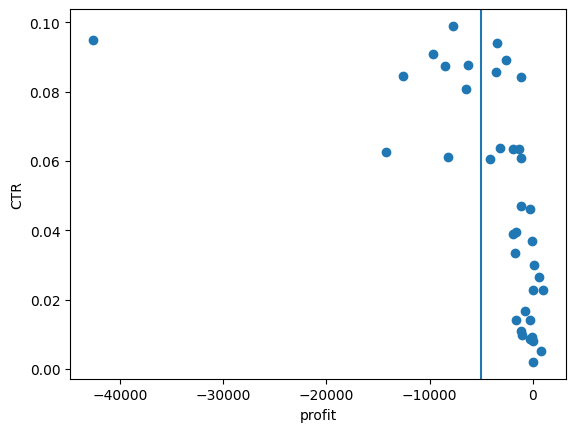

In [37]:
plt.scatter('profit','CTR',data=group_data)
plt.xlabel('profit')
plt.ylabel('CTR')
plt.axvline(x=-5000)
plt.show()

draw a line at profit -5000, eliminate those lower than. keep those higher than and find highest CTR
profit is almost all negative becasuse user LTV is unknown. incorporate those and profit should be positive

In [38]:
top_5 = group_data.query('profit > -5000').sort_values('CTR',ascending=False).head(5)
top_5

,ad,date,shown,clicked,converted,avg_cost_per_click,total_revenue,CTR,profit
10,ad_group_19,2015-10-26 13:23:04.615384576,19506.884615,1836.461538,48.173077,2.257500,731.529808,0.094188,-3460.419038
19,ad_group_28,2015-10-27 00:00:00.000000000,19886.339623,1770.792453,55.962264,1.970755,864.178868,0.089191,-2644.280943
4,ad_group_13,2015-10-26 22:07:03.529411840,161519.176471,13841.980392,1308.647059,1.740392,20685.530000,0.085635,-3573.196275
26,ad_group_34,2015-10-27 00:00:00.000000000,35371.622642,2979.169811,260.320755,1.733208,4019.534340,0.084257,-1189.270000
34,ad_group_5,2015-10-27 06:55:23.076923136,52406.461538,3343.173077,215.538462,2.027308,3574.216923,0.063862,-3233.796538


# Question 2: 
# Predict ads shown on Dec 15 for a sample ad group

In [39]:
%pip install Prophet 

Note: you may need to restart the kernel to use updated packages.


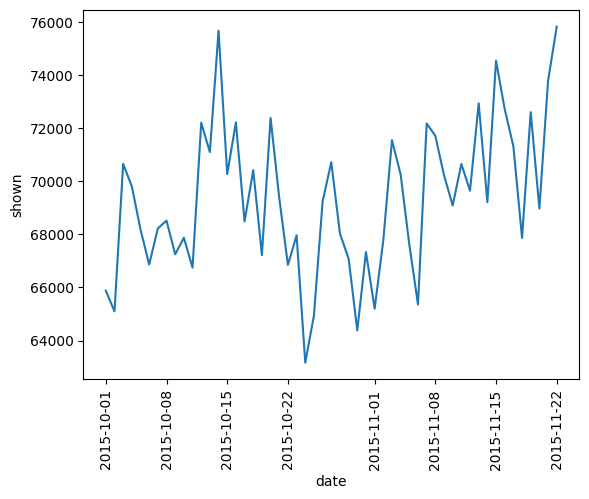

In [44]:
from prophet import Prophet

data_ad1 = data.query('ad==\"ad_group_1\"')[["date", "shown"]]
# data_ad1

g = plt.plot('date','shown', data =data_ad1 )
plt.xlabel('date')
plt.ylabel('shown')
plt.xticks(rotation = 90)
plt.show()

15:42:14 - cmdstanpy - INFO - Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1] done processing


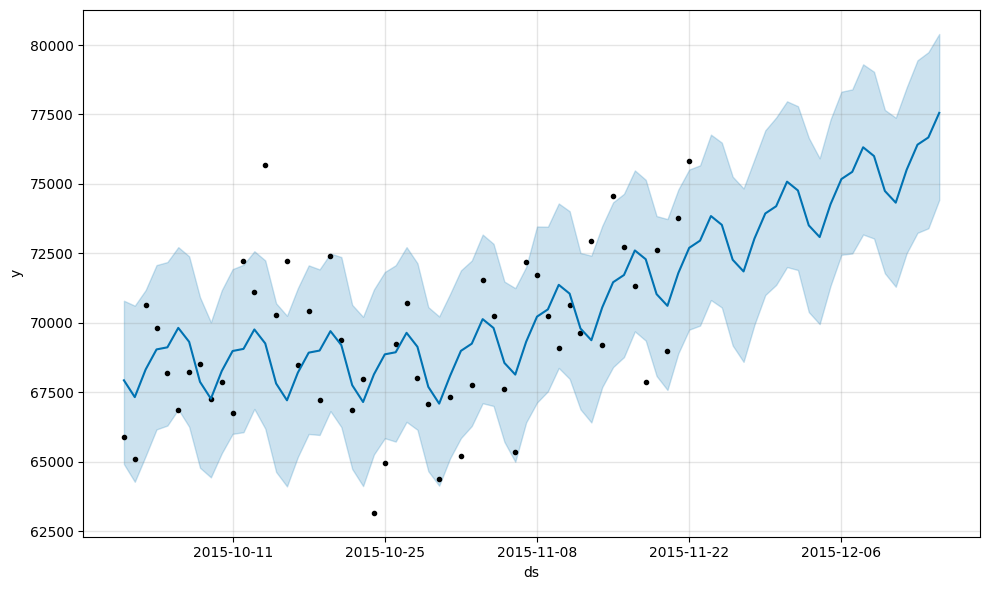

In [59]:
#build the time series
data_ad1.rename(columns={'date':'ds', 'shown':'y'},
                inplace= True)

model = Prophet()
model.fit(data_ad1)

#calc # of  days to predict
days_predict = (pd.to_datetime('2015-12-15') - data_ad1['ds'].max()).days

#make predictions
future_data = model.make_future_dataframe(periods = days_predict)
predictions = model.predict(future_data)
# print(predictions)


model.plot(predictions);
#the ; above makes sure graph is printed only once

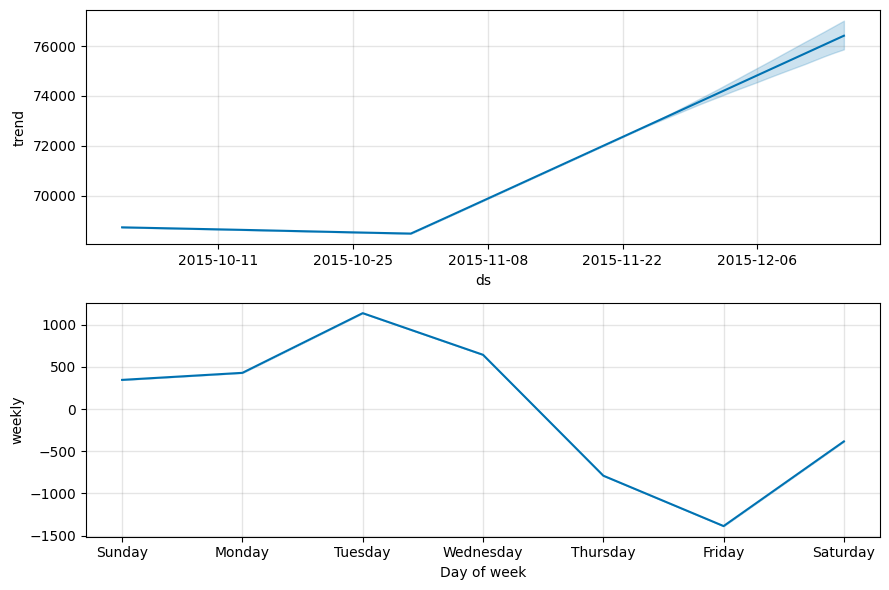

In [58]:
model.plot_components(predictions);

# Question 2:
# Predict ads shown for all ad groups

In [ ]:
data_ad1 = data.query('ad==\"ad_group_1\"')[["date", "shown"]]

#build the time series
data_ad1.rename(columns={'date':'ds', 'shown':'y'},
                inplace= True)

model = Prophet()
model.fit(data_ad1)

#calc # of  days to predict
days_predict = (pd.to_datetime('2015-12-15') - data_ad1['ds'].max()).days

#make predictions
future_data = model.make_future_dataframe(periods = days_predict)
predictions = model.predict(future_data)
# print(predictions)


model.plot(predictions);
#the ; above makes sure graph is printed only once

In [66]:
predictions_all = pd.DataFrame({'ad_group':data['ad'].unique(),
                                'date': pd.to_datetime('2015-12-15')
                                })
predictions_dec_15 = []


for level in predictions_all.ad_group:
    tmp = data.loc[data['ad']== level][['date','shown']]

    tmp.rename(columns={'date':'ds','shown':'y'},
               inplace=True)
    
    tmp_model = Prophet()
    tmp_model.fit(tmp)

    #calc # of  days to predict
    tmp_days_predict = (pd.to_datetime('2015-12-15') - tmp['ds'].max()).days

    #make predictions
    tmp_future_data = tmp_model.make_future_dataframe(periods= tmp_days_predict)
    tmp_predictions = tmp_model.predict(tmp_future_data)


    predictions_dec_15.append(round(tmp_predictions['yhat'].iat[-1]))



16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1] done processing
16:12:25 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1]

[77558,
 50305,
 152888,
 94679,
 54749,
 40587,
 56988,
 47171,
 124642,
 127043,
 19964,
 28000,
 162073,
 8715,
 15773,
 30494,
 134101,
 89749,
 19889,
 120417,
 28320,
 26866,
 48616,
 37394,
 72261,
 65385,
 20983,
 21327,
 110710,
 123615,
 39847,
 16240,
 38683,
 60008,
 71430,
 71485,
 177108,
 26122,
 80638]

In [70]:
predictions_all['predictions'] = predictions_dec_15
predictions_all.sort_values('predictions',ascending=False)

,ad_group,date,predictions
36,ad_group_38,2015-12-15,177108
12,ad_group_13,2015-12-15,162073
2,ad_group_3,2015-12-15,152888
16,ad_group_17,2015-12-15,134101
9,ad_group_10,2015-12-15,127043
8,ad_group_9,2015-12-15,124642
29,ad_group_31,2015-12-15,123615
19,ad_group_20,2015-12-15,120417
28,ad_group_30,2015-12-15,110710
3,ad_group_4,2015-12-15,94679


# Question 3:
# Cluster ads into 3 groups

(array([16709., 16716., 16723., 16730., 16740., 16747., 16754., 16761.]),
 [Text(16709.0, 0, '2015-10-01'),
  Text(16716.0, 0, '2015-10-08'),
  Text(16723.0, 0, '2015-10-15'),
  Text(16730.0, 0, '2015-10-22'),
  Text(16740.0, 0, '2015-11-01'),
  Text(16747.0, 0, '2015-11-08'),
  Text(16754.0, 0, '2015-11-15'),
  Text(16761.0, 0, '2015-11-22')])

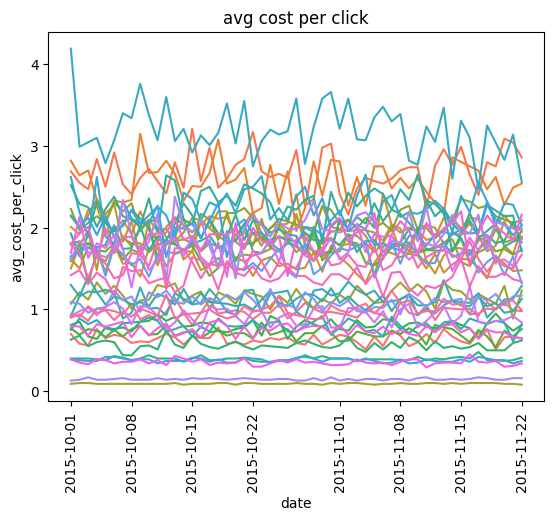

In [82]:
g = sns.lineplot(x= 'date', y= 'avg_cost_per_click',hue = 'ad',data = data, legend="")
g.set_title('avg cost per click')
plt.xticks(rotation = 90)

In [125]:
import statsmodels.api as sm

coefficient = []
p_value = []


for level in data['ad'].unique():
    #subset dataset and keep variables we care about
    data_reg = data.loc[data['ad'] ==level][['date','avg_cost_per_click']]
    
    #replace dates with numbers. 0 is the minimum date, 1 is minimum date + 1 day and so on
    data_reg['date'] = (data_reg['date'] - data_reg['date'].min()).dt.days
    # print(data_reg)

    #add intercept
    data_reg['intercept'] = 1

    #build the regression
    y= data_reg['avg_cost_per_click']
    x = data_reg.drop('avg_cost_per_click',axis = 1)

    lr = sm.OLS(y, x).fit()

    #save coefficient and p-value
    coefficient.append(lr.params[0])
    p_value.append(lr.pvalues[0])

#put all together in a datframe
lr_output = pd.DataFrame({'ad_group':data['ad'].unique(),
                          'coefficients': coefficient,
                           'p_values': p_value
                           })

lr_output['cluster'] = ""

def assign_cluster(p_value, coefficient):
    if p_value > 0.05/40:
        return 'flat'
    else:
        if coefficient > 0:
            return 'going up'
        else:
            return 'going down'


for i in range(len(lr_output)):
    lr_output.loc[i,'cluster'] = assign_cluster( lr_output.loc[i,'p_values'],
                                                lr_output.loc[i,'coefficients'],
                                                )

lr_output.groupby('cluster').count()


#classify based on the rule described above. we use Bonferroni rule for significance

,ad_group,coefficients,p_values
cluster,,,
flat,39,39,39
